# Embeddings / Transformers / Similarity Search

## Scenario

We use a **University domain** aligned with your ontology and Neo4j notebooks:
- People: Alice, Bob
- Roles: Student, Professor
- Research group: EnergyAIGroup
- Competency questions: “Who supervises Alice?”, “Who works on neuro-symbolic reasoning?”

## Learning outcomes
1. Understand tokenization and its impact on domain terms
2. Extract embeddings from a transformer and compute similarity
3. See why embeddings help semantic retrieval but not logical entailment
4. Connect these primitives to later RAG and Neo4j labs


---
## 0) Setup
We will use a small Hugging Face model for fast execution.

### What this cell is doing
- Installs/loads the libraries required to run transformer models in Colab.
- We use a small encoder model so we can *inspect* tokens and embeddings quickly.


In [1]:
!pip -q install -U transformers torch sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32

### What this cell is doing
- Installs/loads the libraries required to run transformer models in Colab.
- We use a small encoder model so we can *inspect* tokens and embeddings quickly.


In [2]:
# Load a small encoder model for fast, inspectable embeddings
import torch
from transformers import AutoTokenizer, AutoModel

torch.set_grad_enabled(False)

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

print("Loaded:", MODEL_NAME)
print("Torch:", torch.__version__)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loaded: sentence-transformers/all-MiniLM-L6-v2
Torch: 2.9.1+cu128


---
## 1) Authentic mini-corpus (aligned to ontology/Neo4j lab)

### What this cell is doing
- Defines a tiny University-domain corpus (profiles, group description, policy).
- This mirrors text you might attach to nodes in Neo4j (e.g., `Person.profile`).


In [3]:
# University-domain mini-corpus used throughout the workshop
corpus = {
  "Alice_profile": "Alice is a PhD student researching neuro-symbolic AI, knowledge graphs, and reasoning systems.",
  "Bob_profile": "Bob is a Professor working on ontology engineering and graph-based AI. He supervises students.",
  "EnergyAIGroup_desc": "EnergyAIGroup focuses on AI for sustainability, energy forecasting, optimisation, and climate modelling.",
  "Policy_note": "Use least-privilege access for LLM tools. Prefer read-only database access for student labs. Validate generated queries."
}
list(corpus.keys())

['Alice_profile', 'Bob_profile', 'EnergyAIGroup_desc', 'Policy_note']

---
## 2) Tokenization: what the model actually sees

### What this cell is doing
- Shows subword tokenization and token IDs.
- Tokenization changes (hyphens/casing) can affect embeddings and retrieval.


In [4]:
# Tokenization inspection: text → tokens → IDs
text = corpus["Alice_profile"]
tokens = tokenizer.tokenize(text)
ids = tokenizer.encode(text, add_special_tokens=True)

print("Text:", text)
print("Tokens (first 40):", tokens[:40])
print("Token count:", len(tokens))
print("IDs (first 20):", ids[:20])

Text: Alice is a PhD student researching neuro-symbolic AI, knowledge graphs, and reasoning systems.
Tokens (first 40): ['alice', 'is', 'a', 'phd', 'student', 'researching', 'ne', '##uro', '-', 'symbolic', 'ai', ',', 'knowledge', 'graphs', ',', 'and', 'reasoning', 'systems', '.']
Token count: 19
IDs (first 20): [101, 5650, 2003, 1037, 8065, 3076, 20059, 11265, 10976, 1011, 12613, 9932, 1010, 3716, 19287, 1010, 1998, 13384, 3001, 1012]


### Quick exercise
Try variants of 'neuro-symbolic' and observe tokenization differences.

### What this cell is doing
- Shows subword tokenization and token IDs.
- Tokenization changes (hyphens/casing) can affect embeddings and retrieval.


In [5]:
# Tokenization inspection: text → tokens → IDs
variants = [
  "Alice works on neuro symbolic reasoning.",
  "Alice works on neuro-symbolic reasoning.",
  "Alice works on NeuroSymbolic reasoning."
]

for v in variants:
    toks = tokenizer.tokenize(v)
    print("\n", v)
    print("tokens:", toks)


 Alice works on neuro symbolic reasoning.
tokens: ['alice', 'works', 'on', 'ne', '##uro', 'symbolic', 'reasoning', '.']

 Alice works on neuro-symbolic reasoning.
tokens: ['alice', 'works', 'on', 'ne', '##uro', '-', 'symbolic', 'reasoning', '.']

 Alice works on NeuroSymbolic reasoning.
tokens: ['alice', 'works', 'on', 'ne', '##uro', '##sy', '##mbo', '##lic', 'reasoning', '.']


### What is Attention?

Transformers use a mechanism called **attention** to decide which words in a sentence
should influence each other.

Instead of reading text word-by-word, the model:
- looks at **all words at once**
- learns which words are **more important to each other**
- updates each word’s representation based on its context

For example, in the sentence:

> “Alice works on neuro-symbolic reasoning”

the word *“Alice”* becomes strongly connected to *“works”* and *“reasoning”*.

After attention is applied:
- each word (token) has a **context-aware vector**
- these vectors already “know” something about the whole sentence

In this workshop, we **do not inspect attention weights directly**.
Instead, we use the *result* of attention — the token embeddings —
and combine them to form a single **sentence embedding**.

This is exactly the representation used later for:
- semantic search
- embeddings in vector databases
- Retrieval-Augmented Generation (RAG)


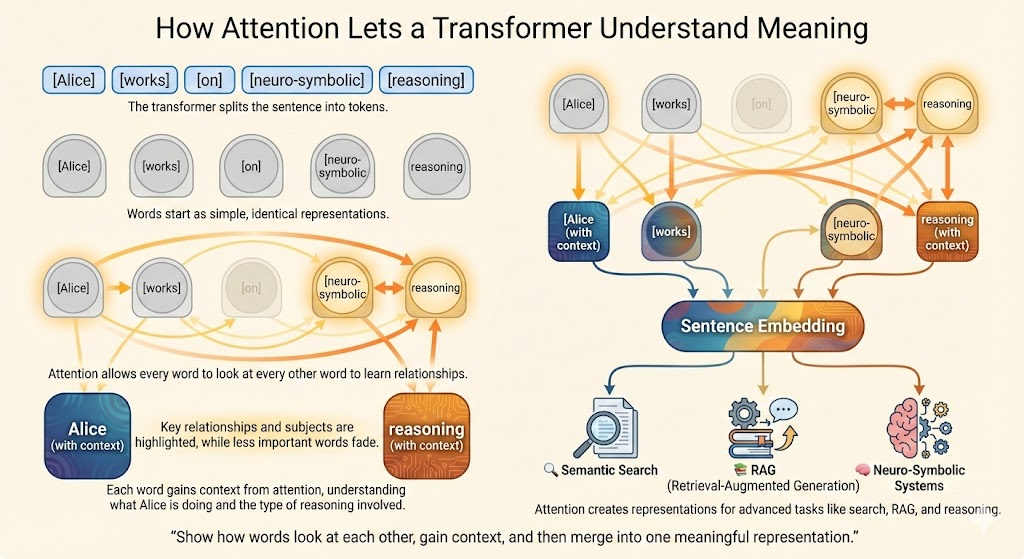

---
## 3) Embeddings: turning text into vectors
We extract sentence embeddings via mean pooling.

### What this cell is doing
- Runs the transformer forward pass to get token embeddings.
- Uses mean pooling to create a single sentence embedding.
- Normalizes embeddings for cosine similarity.


In [6]:
# We want ONE vector to represent the whole sentence.
# The transformer actually gives us ONE vector PER WORD (token),
# so we need to combine them into a single sentence-level embedding.

def mean_pool(last_hidden_state, attention_mask):
    # attention_mask tells us which tokens are real words
    # and which are just padding added to make sentences the same length
    # last_hidden_state is the set of final, context-aware vectors for
    # every token in the sentence after the transformer has finished processing it

    # Expand the mask so it matches the shape of the token embeddings
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()

    # Zero-out embeddings that belong to padding tokens
    masked = last_hidden_state * mask

    # Add up all the token embeddings for each sentence
    summed = masked.sum(dim=1)

    # Count how many real (non-padding) tokens we had
    counts = mask.sum(dim=1).clamp(min=1e-9)

    # Average the token embeddings → one vector for the whole sentence
    return summed / counts


def embed_sentence(s: str):
    # Step 1: Convert text into tokens the model understands
    inputs = tokenizer(s, return_tensors="pt", truncation=True, padding=True)

    # Step 2: Run the text through the transformer
    # This gives us a vector for EACH token in the sentence
    outputs = model(**inputs)

    # Step 3: Combine all token vectors into one sentence vector
    emb = mean_pool(outputs.last_hidden_state, inputs["attention_mask"])

    # Step 4: Normalize the vector so we can compare sentences fairly
    # (important for cosine similarity later)
    emb = torch.nn.functional.normalize(emb, p=2, dim=1)

    return emb[0]


# Build embeddings for every text snippet in our corpus
# Each entry now has a numeric vector representation
embeddings = {k: embed_sentence(v) for k, v in corpus.items()}

# Show the size of the embedding vector
print("Embedding dim:", embeddings["Alice_profile"].shape[0])


Embedding dim: 384


---
## 4) Similarity search (in-memory)
Compute cosine similarity and retrieve top matches.

### What this cell is doing
- Embeds a question and ranks corpus entries by cosine similarity.
- This is the core mechanic behind vector search and RAG retrieval.


In [7]:
# This function measures how similar two sentence embeddings are.
# We use cosine similarity, which compares the *direction* of vectors,
# not their length. Higher = more similar meaning.
def cos(a, b):
    return float(torch.dot(a, b).item())


# This is the natural-language question we want to search for
query = "Who works on neuro-symbolic reasoning?"

# Convert the question into an embedding vector
# This puts the question into the same vector space as our corpus texts
q_emb = embed_sentence(query)


# Compare the query embedding to every document embedding
# For each document, we store:
# - the document key (k)
# - the similarity score
# - the original text
scored = [
    (k, cos(q_emb, v), corpus[k])
    for k, v in embeddings.items()
]


# Sort documents by similarity score (highest first)
# This simulates how a vector database ranks results
scored.sort(key=lambda x: x[1], reverse=True)


# Print out the ranked results
# This lets us see which texts the model thinks are most relevant
for k, score, txt in scored:
    print(f"{k:18}  score={score:.3f}  text={txt}")


Alice_profile       score=0.663  text=Alice is a PhD student researching neuro-symbolic AI, knowledge graphs, and reasoning systems.
Bob_profile         score=0.377  text=Bob is a Professor working on ontology engineering and graph-based AI. He supervises students.
EnergyAIGroup_desc  score=0.249  text=EnergyAIGroup focuses on AI for sustainability, energy forecasting, optimisation, and climate modelling.
Policy_note         score=0.123  text=Use least-privilege access for LLM tools. Prefer read-only database access for student labs. Validate generated queries.



Embeddings retrieve *similar text*.
They do **not** guarantee logical entailment (e.g., Professor ⊑ Academic) or path explanations.
That is why we might use something like a graph database (Neo4J).


---
## 5) Relationship questions: why graphs matter

### What this cell is doing
- Repeats similarity search for a relationship question.
- Demonstrates that embeddings retrieve *related text* but do not compute graph relationships.


In [8]:
# Relationship question: similarity retrieval is not a graph join
query2 = "Who supervises Alice?"
q2 = embed_sentence(query2)

scored2 = [(k, cos(q2, v), corpus[k]) for k, v in embeddings.items()]
scored2.sort(key=lambda x: x[1], reverse=True)

for k, score, txt in scored2:
    print(f"{k:18}  score={score:.3f}  text={txt}")

Alice_profile       score=0.496  text=Alice is a PhD student researching neuro-symbolic AI, knowledge graphs, and reasoning systems.
Bob_profile         score=0.399  text=Bob is a Professor working on ontology engineering and graph-based AI. He supervises students.
EnergyAIGroup_desc  score=0.172  text=EnergyAIGroup focuses on AI for sustainability, energy forecasting, optimisation, and climate modelling.
Policy_note         score=0.113  text=Use least-privilege access for LLM tools. Prefer read-only database access for student labs. Validate generated queries.


### [THOUGHT PROMPT]
Why is the correct answer to “Who supervises Alice?” better served by a **graph query** (Cypher) than embedding similarity?


---
## 6) Bridge to the next notebooks
Next, you will:
1) Build a vector index (FAISS / Neo4jVector)
2) Add an LLM for RAG (retrieval + generation)
3) Move to Neo4j for explicit relationships and explanations
4) Use GraphCypherQAChain for NL→Cypher
5) Connect to VTB as a neuro-symbolic reasoning frontier
